# K562 cell-line overlap between Repli Hi-C and Hi-C

In [1]:
import sys
sys.path.append('..')
from utils.plotting import plot_hic, plot_n_hic, genomic_labels, format_ticks

from notebooks.func_analysis import *
from notebooks.func_plotting import *
from notebooks.func_iou import *
from notebooks.func_pileup import *

import os
import itertools
import pybedtools
from matplotlib_venn import venn2
from collections import defaultdict
from pyBedGraph import BedGraph
import subprocess
import yaml


from io import StringIO

## Start

In [2]:
# Analysis parameters
save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"
result_type = "saliency-90-p-0.1" # MIA-Jet

# Pileup parameters
data_type = "oe"
expected_stack_size = 100

# Overlap parameters
iou_threshold = 0  # ANY overlap

insituhic_file = "/nfs/turbo/umms-minjilab/downloaded_data/K562_hic_Rao-2014_ENCFF616PUW_hg38.hic" # hg38
intacthic_file = "/nfs/turbo/umms-minjilab/downloaded_data/K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38.hic" # hg38
replihic_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic" # hg19

data_name = "K562 cell-line"

resolution = 50000 # 50Kb resolution
normalization = "VC_SQRT"

# Overlap parameter is relative to resolution
buffer_radius = 3 * resolution  

# FUN
f_pred_fun_replihic_bedpe = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_Repli-HiC_K562_WT_totalS/FUN-pred_50000_1.3.bedpe"
f_pred_fun_replihic_tab = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_Repli-HiC_K562_WT_totalS/FUN-pred_50000_1.3.tab"

f_pred_fun_insituhic_bedpe = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_K562_hic_Rao-2014_ENCFF616PUW_hg38/FUN-pred_50000_1.3.bedpe"
f_pred_fun_insituhic_tab = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_K562_hic_Rao-2014_ENCFF616PUW_hg38/FUN-pred_50000_1.3.tab"

f_pred_fun_intacthic_bedpe = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38/FUN-pred_50000_1.3.bedpe"
f_pred_fun_intacthic_tab = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38/FUN-pred_50000_1.3.tab"

# FONTANKA
# for Repli Hi-C use weak thresholded
f_pred_fontanka_replihic = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_Repli-HiC_K562_WT_totalS.50000.predicted.fountains.thresholded-weak.tsv" 
f_pred_fontanka_insituhic = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_K562_hic_Rao-2014_ENCFF616PUW_hg38.50000.predicted.fountains.thresholded-weak.tsv"
f_pred_fontanka_intacthic = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38.50000.predicted.fountains.thresholded-weak.tsv"

# MIA-JET
f_pred_miajet_replihic_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/Repli-HiC_K562_WT_totalS_chr_combined_{genomic_labels(resolution)}/Repli-HiC_K562_WT_totalS_chr_combined_{result_type}_{genomic_labels(resolution)}_summary_table.csv"
f_pred_miajet_replihic_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/Repli-HiC_K562_WT_totalS_chr_combined_{genomic_labels(resolution)}/Repli-HiC_K562_WT_totalS_chr_combined_{result_type}_{genomic_labels(resolution)}_expanded_table.csv"

f_pred_miajet_insituhic_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/K562_hic_Rao-2014_ENCFF616PUW_hg38_chr_combined_{genomic_labels(resolution)}/K562_hic_Rao-2014_ENCFF616PUW_hg38_chr_combined_{result_type}_{genomic_labels(resolution)}_summary_table.csv"
f_pred_miajet_insituhic_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/K562_hic_Rao-2014_ENCFF616PUW_hg38_chr_combined_{genomic_labels(resolution)}/K562_hic_Rao-2014_ENCFF616PUW_hg38_chr_combined_{result_type}_{genomic_labels(resolution)}_expanded_table.csv"

f_pred_miajet_intacthic_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38_chr_combined_{genomic_labels(resolution)}/K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38_chr_combined_{result_type}_{genomic_labels(resolution)}_summary_table.csv"
f_pred_miajet_intacthic_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38_chr_combined_{genomic_labels(resolution)}/K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38_chr_combined_{result_type}_{genomic_labels(resolution)}_expanded_table.csv"   

names = [
    "Repli-HiC_K562_WT_totalS (hg19)",
    "In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38",
    "Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38"
]

genomes = [
    "hg19",
    "hg38",
    "hg38"
]

fun_bedpe_list = [
    f_pred_fun_replihic_bedpe,
    f_pred_fun_insituhic_bedpe,
    f_pred_fun_intacthic_bedpe
]

fun_table_list = [
    f_pred_fun_replihic_tab,
    f_pred_fun_insituhic_tab,
    f_pred_fun_intacthic_tab
]

fontanka_table_list = [ 
    f_pred_fontanka_replihic,
    f_pred_fontanka_insituhic,
    f_pred_fontanka_intacthic
]

miajet_table_list = [
    f_pred_miajet_replihic_summary,
    f_pred_miajet_insituhic_summary,
    f_pred_miajet_intacthic_summary
]

miajet_position_list = [
    f_pred_miajet_replihic_expanded,
    f_pred_miajet_insituhic_expanded,
    f_pred_miajet_intacthic_expanded
]

In [3]:
chrom_sizes = bf.fetch_chromsizes("hg19", as_bed=True)
common_chroms = chrom_sizes['chrom'].tolist()
print(common_chroms) # Should be same for hg38

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']


In [3]:
select_method_idx = 2 # select MIA-Jet
method_names = [f"MIA-Jet {result_type}", "Fun", "Fontanka"]
ranking_col = ["jet_saliency", "SoN", "FS_peaks"]

selected_method = method_names[select_method_idx]
data_name += f" ({selected_method})"

tables = []
positions = []

# Process all at once
for i in range(len(names)):
    name = names[i]

    f_fun_bedpe = fun_bedpe_list[i]
    f_fun_table = fun_table_list[i]
    f_fontanka_table = fontanka_table_list[i]
    f_miajet_table = miajet_table_list[i]
    f_miajet_position = miajet_position_list[i]

    # Load it in
    fun_bedpe = pd.read_csv(f_fun_bedpe, sep="\t")
    fun_table = pd.read_csv(f_fun_table, sep="\t")

    fontanka_table = pd.read_csv(f_fontanka_table, sep="\t", index_col=0)
    fontanka_table.dropna(inplace=True, how="any")
    fontanka_table.reset_index(inplace=True, drop=True)

    miajet_positions = pd.read_csv(f_miajet_position, comment="#")
    miajet_table = pd.read_csv(f_miajet_table, comment="#")

    # Process FUN
    fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
    fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2
    assert np.all(fun_bedpe["extrusion_x"] >= fun_bedpe["extrusion_y"])

    fun_table["root"] = (fun_table["start"] + fun_table["end"]) / 2
    fun_table["unique_id"] = fun_table.index


    fun_minimal = fun_bedpe.copy()
    fun_minimal["root"] = fun_table["root"]

    fun_minimal["unique_id"] = fun_minimal.index
    fun_minimal["chrom"] = fun_table["chrom"]

    fun_minimal = fun_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

    fun_positions = generate_positions(fun_minimal, resolution)
    fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

    lengths = fun_positions.groupby('unique_id').apply(lambda x : compute_length(x, p=2), include_groups=False)
    fun_table["length"] = lengths

    # Process FONTANKA
    fontanka_table = fontanka_table.reset_index(drop=True)
    fontanka_table["root"] = (fontanka_table["end"] + fontanka_table["start"]) / 2
    fontanka_table["unique_id"] = fontanka_table.index
    fontanka_table["extrusion_x"] = fontanka_table["window_end"]
    fontanka_table["extrusion_y"] = fontanka_table["window_start"]
    assert np.all(fontanka_table["extrusion_x"] >= fontanka_table["extrusion_y"])

    fontanka_table["length"] = -1

    fontanka_minimal = fontanka_table.copy()
    fontanka_minimal = fontanka_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

    fontanka_positions = generate_positions(fontanka_minimal, resolution)
    fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)    

    if select_method_idx == 0:
        tables.append(miajet_table)
        positions.append(miajet_positions)
    elif select_method_idx == 1:
        tables.append(fun_table)
        positions.append(fun_positions)
    elif select_method_idx == 2:
        tables.append(fontanka_table)
        positions.append(fontanka_positions)

In [4]:
# The 3 objects that Venn Diagram notebook uses
# We make a new object for proper Hi-C read-in
hic_file = [replihic_file, insituhic_file, intacthic_file]
names_abbrev = ["Repli Hi-C", "In situ Hi-C", "Intact Hi-C"]
names

['Repli-HiC_K562_WT_totalS (hg19)',
 'In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38',
 'Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38']

In [6]:
tables[0]

chrom      start        end name       SoN strand  \
0    chr1  199500000  199550000    .  0.001315      .   
1    chr1  242600000  242650000    .  0.001390      .   
2    chr1  241900000  241950000    .  0.001177      .   
3    chr1  232700000  232750000    .  0.002119      .   
4    chr1  225200000  225250000    .  0.001712      .   
..    ...        ...        ...  ...       ...    ...   
552  chrX  113350000  113400000    .  0.003575      .   
553  chrX  108100000  108150000    .  0.004194      .   
554  chrX  109400000  109450000    .  0.001076      .   
555  chrX  104700000  104750000    .  0.003605      .   
556  chrX  102400000  102450000    .  0.001407      .   

                                         perc_res_list  max_extension  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          700.0   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          850.0   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          600.0   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          600.0   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         1150.0   
..                                                 ...            ...   
552  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          950.0   
553  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          900.0   
554  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          800.0   
555  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         1200.0   
556  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          400.0   

     signal_noise_upstream  signal_noise_downstream  \
0                 1.219437                 1.660612   
1                 2.503491                 1.395985   
2                 1.866130                 2.195445   
3                 2.093838                 1.541302   
4                 1.960771                 2.201650   
..                     ...                      ...   
552               2.081706                 3.223633   
553               2.307160                 3.122622   
554               1.782126                 1.238146   
555               1.805071                 1.437016   
556               1.976391                 2.307364   

     signal_noise_average_background   p_value         root  unique_id  \
0                           1.406235  0.020748  199525000.0          0   
1                           1.792464  0.004321  242625000.0          1   
2                           2.017437  0.004900  241925000.0          2   
3                           1.775578  0.001021  232725000.0          3   
4                           2.074240  0.000187  225225000.0          4   
..                               ...       ...          ...        ...   
552                         2.529775  0.000039  113375000.0        552   
553                         2.653656  0.000003  108125000.0        553   
554                         1.461148  0.049347  109425000.0        554   
555                         1.600152  0.010932  104725000.0        555   
556                         2.129091  0.025974  102425000.0        556   

           length  
0    9.905806e+05  
1    1.202601e+06  
2    8.492644e+05  
3    8.492644e+05  
4    1.626730e+06  
..            ...  
552  1.343968e+06  
553  1.273283e+06  
554  1.131923e+06  
555  1.697425e+06  
556  5.667892e+05  

[557 rows x 15 columns]

In [7]:
positions[0]

unique_id chrom        x (bp)        y (bp)
0              0  chr1  2.002500e+08  1.988500e+08
1              0  chr1  2.002118e+08  1.988855e+08
2              0  chr1  2.001737e+08  1.989211e+08
3              0  chr1  2.001355e+08  1.989566e+08
4              0  chr1  2.000974e+08  1.989921e+08
...          ...   ...           ...           ...
12068        556  chrX  1.025795e+08  1.022886e+08
12069        556  chrX  1.025409e+08  1.023227e+08
12070        556  chrX  1.025023e+08  1.023568e+08
12071        556  chrX  1.024636e+08  1.023909e+08
12072        556  chrX  1.024250e+08  1.024250e+08

[12073 rows x 4 columns]

In [5]:
position_dict = dict(zip(names, positions))
table_dict = dict(zip(names, tables)) 

bed_tables = []
for i, (s, e) in enumerate(zip(tables, positions)):
    # bed_tables.append(generate_bed_df(s, e, eps=500e3, fraction=0.5))
    bed_tables.append(generate_bed_2(s, e, eps=500e3, fraction=1.5))

In [6]:
# PLOT LENGTH DISTRIBUTION OF ALL CALLED
for i, s in enumerate(tables):

    lengths = s["length"].values

    if lengths[0] == -1:
        print(f"Lengths for {names[i]} are not available, skipping length histogram.")
        continue

    plot_length_histogram(lengths, 
                          title=f"{data_name}\n{names[i]} distribution of lengths (N={len(lengths)})",
                          bins=50,
                          show=True, 
                          save_name=f"{save_path}/{data_name}_length_distribution_{names[i]}.png"
                        )

Lengths for Repli-HiC_K562_WT_totalS (hg19) are not available, skipping length histogram.
Lengths for In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38 are not available, skipping length histogram.
Lengths for Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38 are not available, skipping length histogram.


In [10]:
# PLOT ALL CALLED
agg_map = []
vmaxes = []
stacks = []
df_stack = []
resolutions = []
chipseq_stacks = []
# for each 

# resolutions = []
for idx, bed_df in enumerate(bed_tables):
    # Get pileups for each bed_df
    s, d, r = get_pileups_dynamic_resolution(
        hic_file=hic_file[idx],
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=True,
        verbose=True
    )

    # Remove centromeres and resize square stacks
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

    if data_type == "observed":
        s = np.log10(s + 1) # log transform for visualization

    a = np.mean(s, axis=0)
    vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
    agg_map.append(a)  # average over all stacks
    stacks.append(s)  # store the stacks for later use
    df_stack.append(d)  # store the DataFrame for later use
    resolutions.append(r)  # store the resolution for later use

Retrieving pileups: 100%|██████████| 383/383 [00:31<00:00, 12.21it/s]


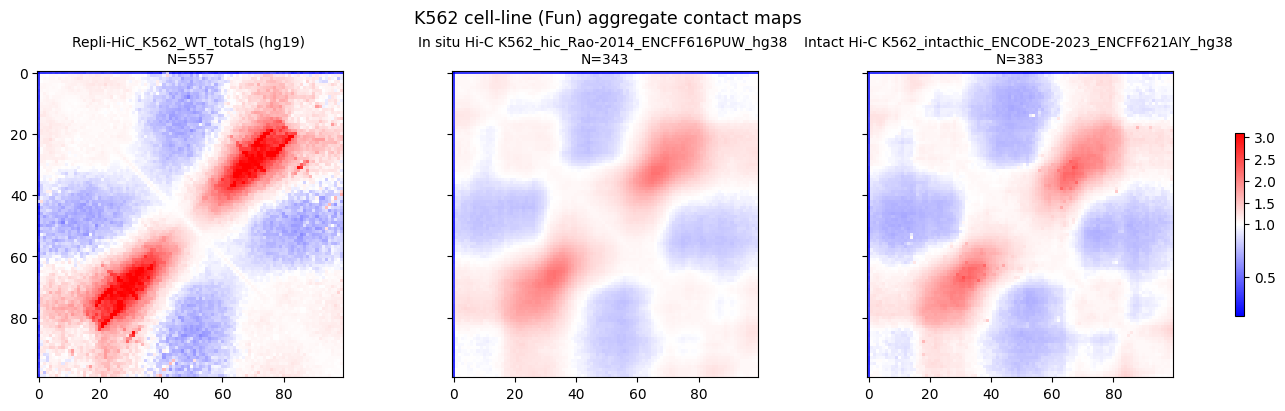

In [11]:
titles = [f"{names[i]} \nN={len(df_stack[i])}" for i in range(len(names))]

plot_n_hic(
    agg_map,
    suptitle=f"{data_name} aggregate contact maps",
    resolution=None,
    cmap_label=None,
    titles=titles,
    cmap='bwr',
    vcenter=1,
    standardize_cbar=True,
    show=True, 
    vmax=vmaxes,
    ppr=4,
    savepath=f"{save_path}/{data_name}_all_agg_map-{data_type}.png"
)

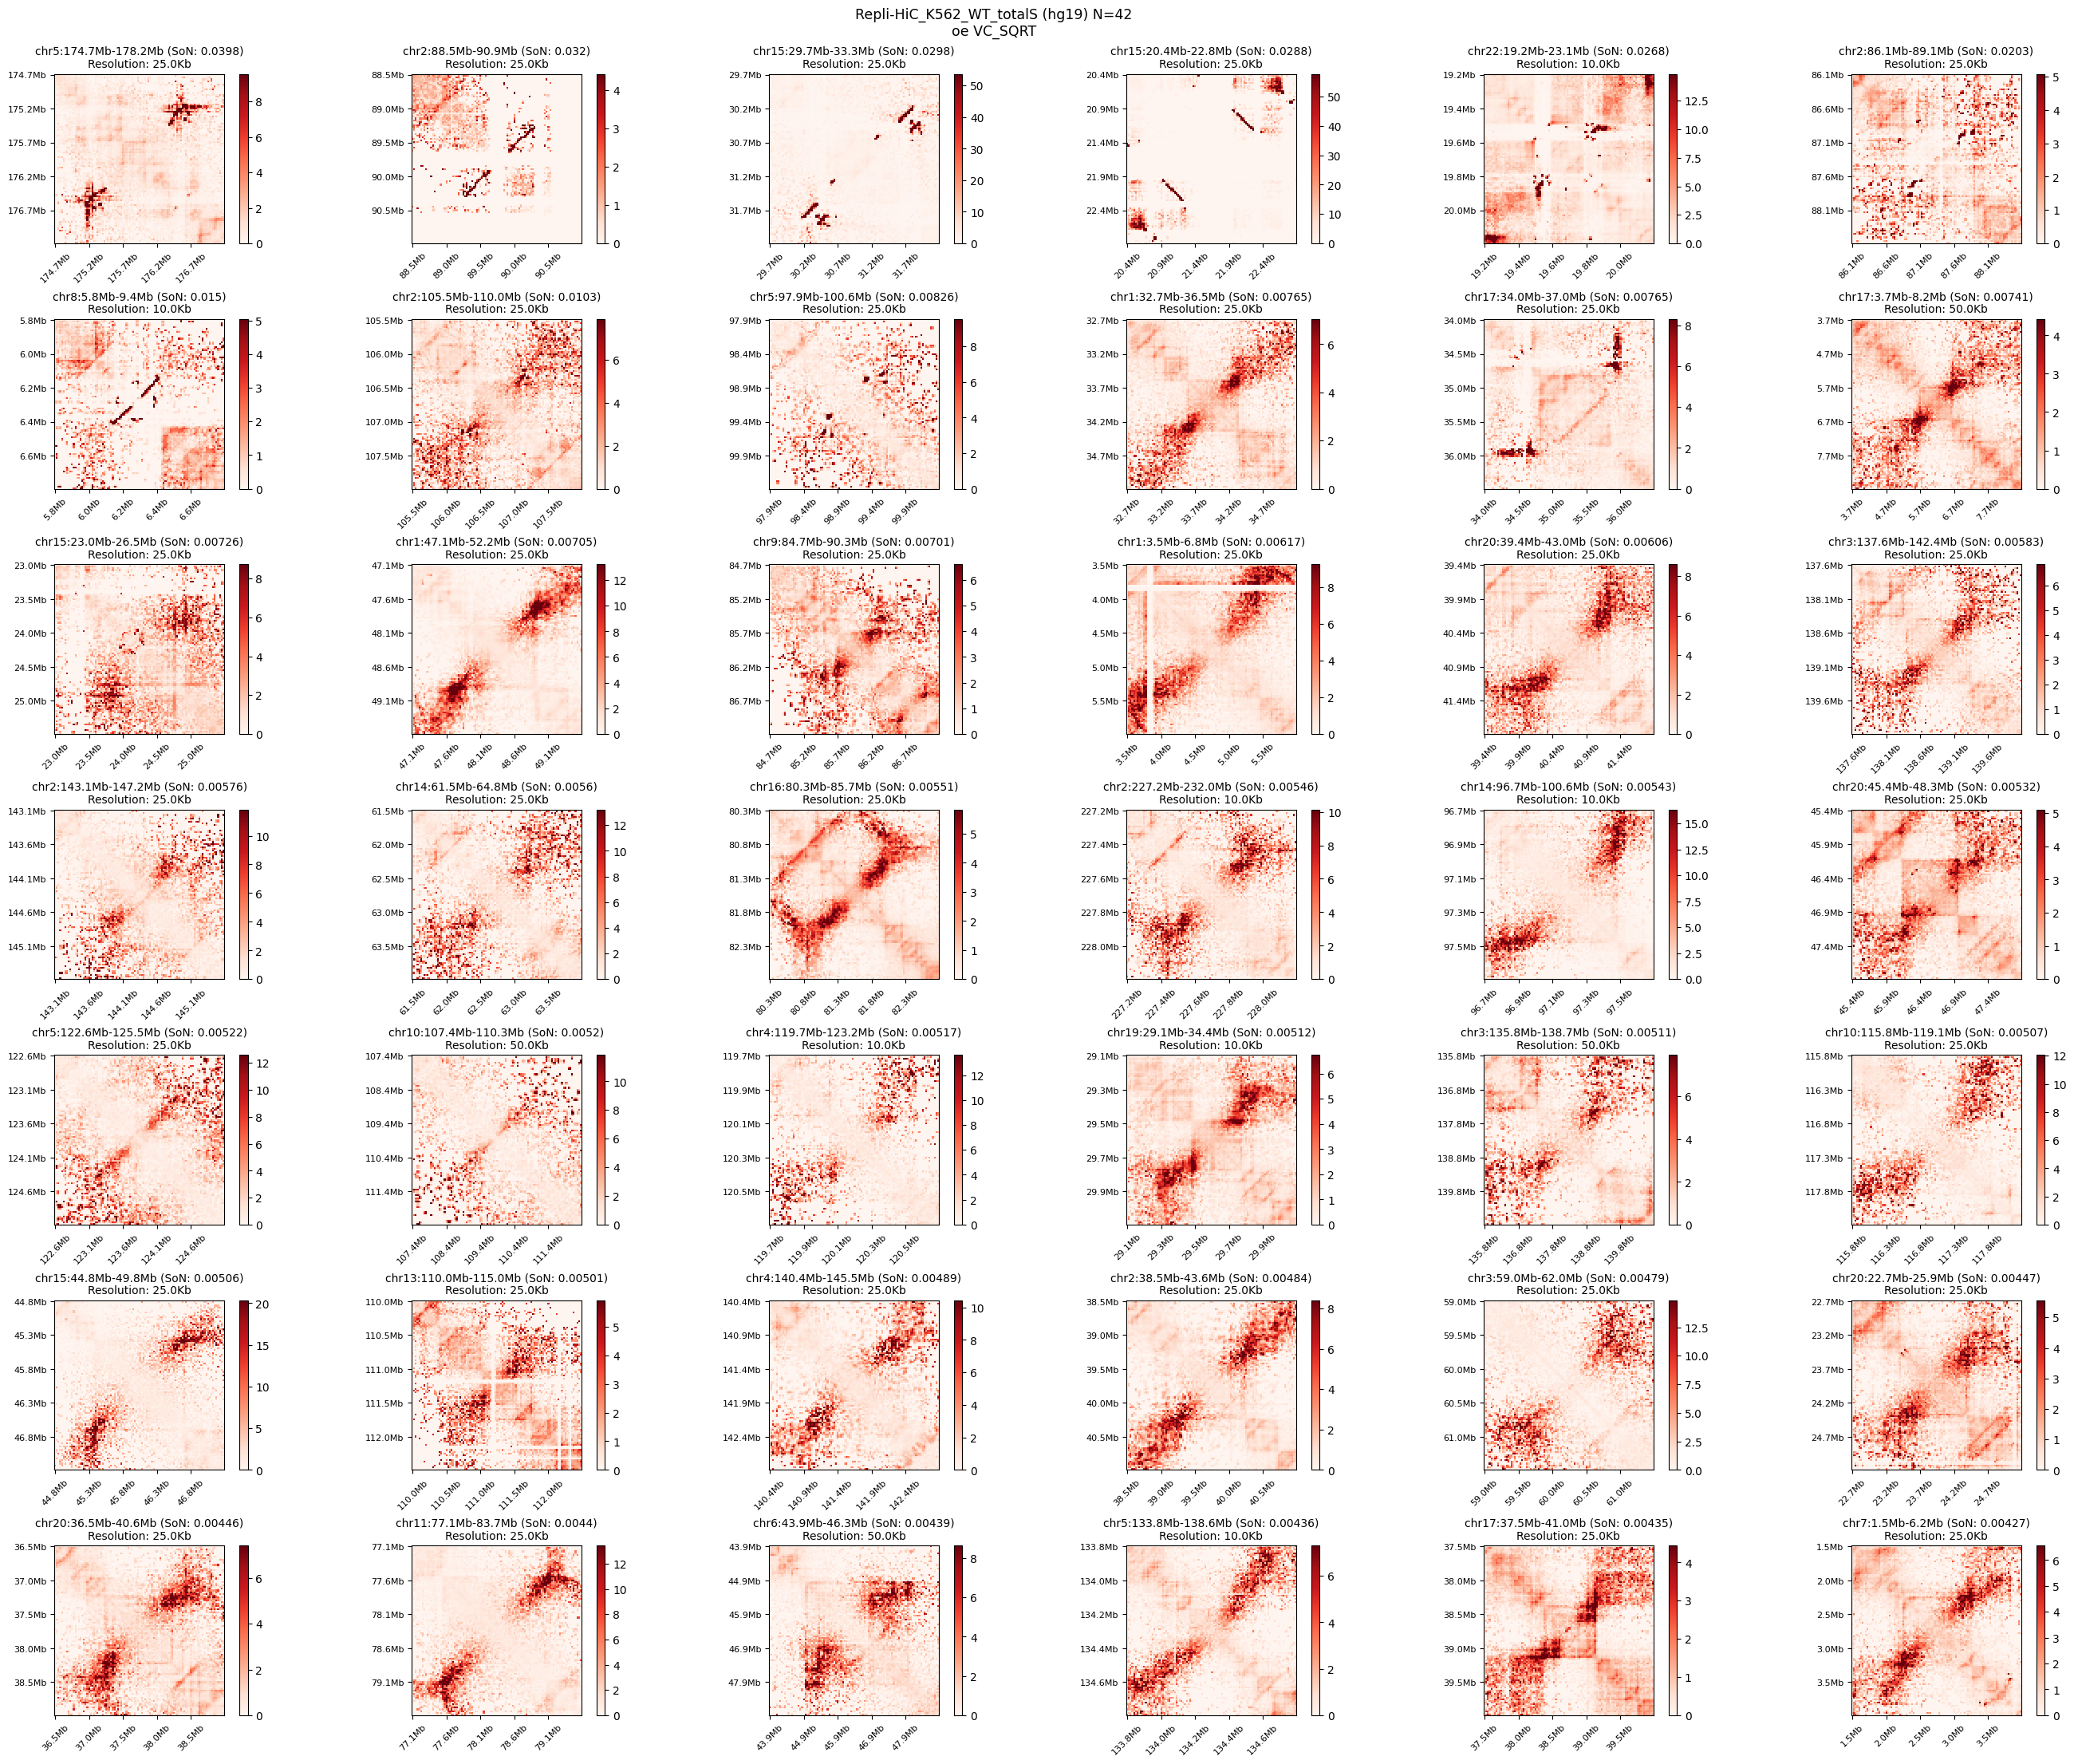

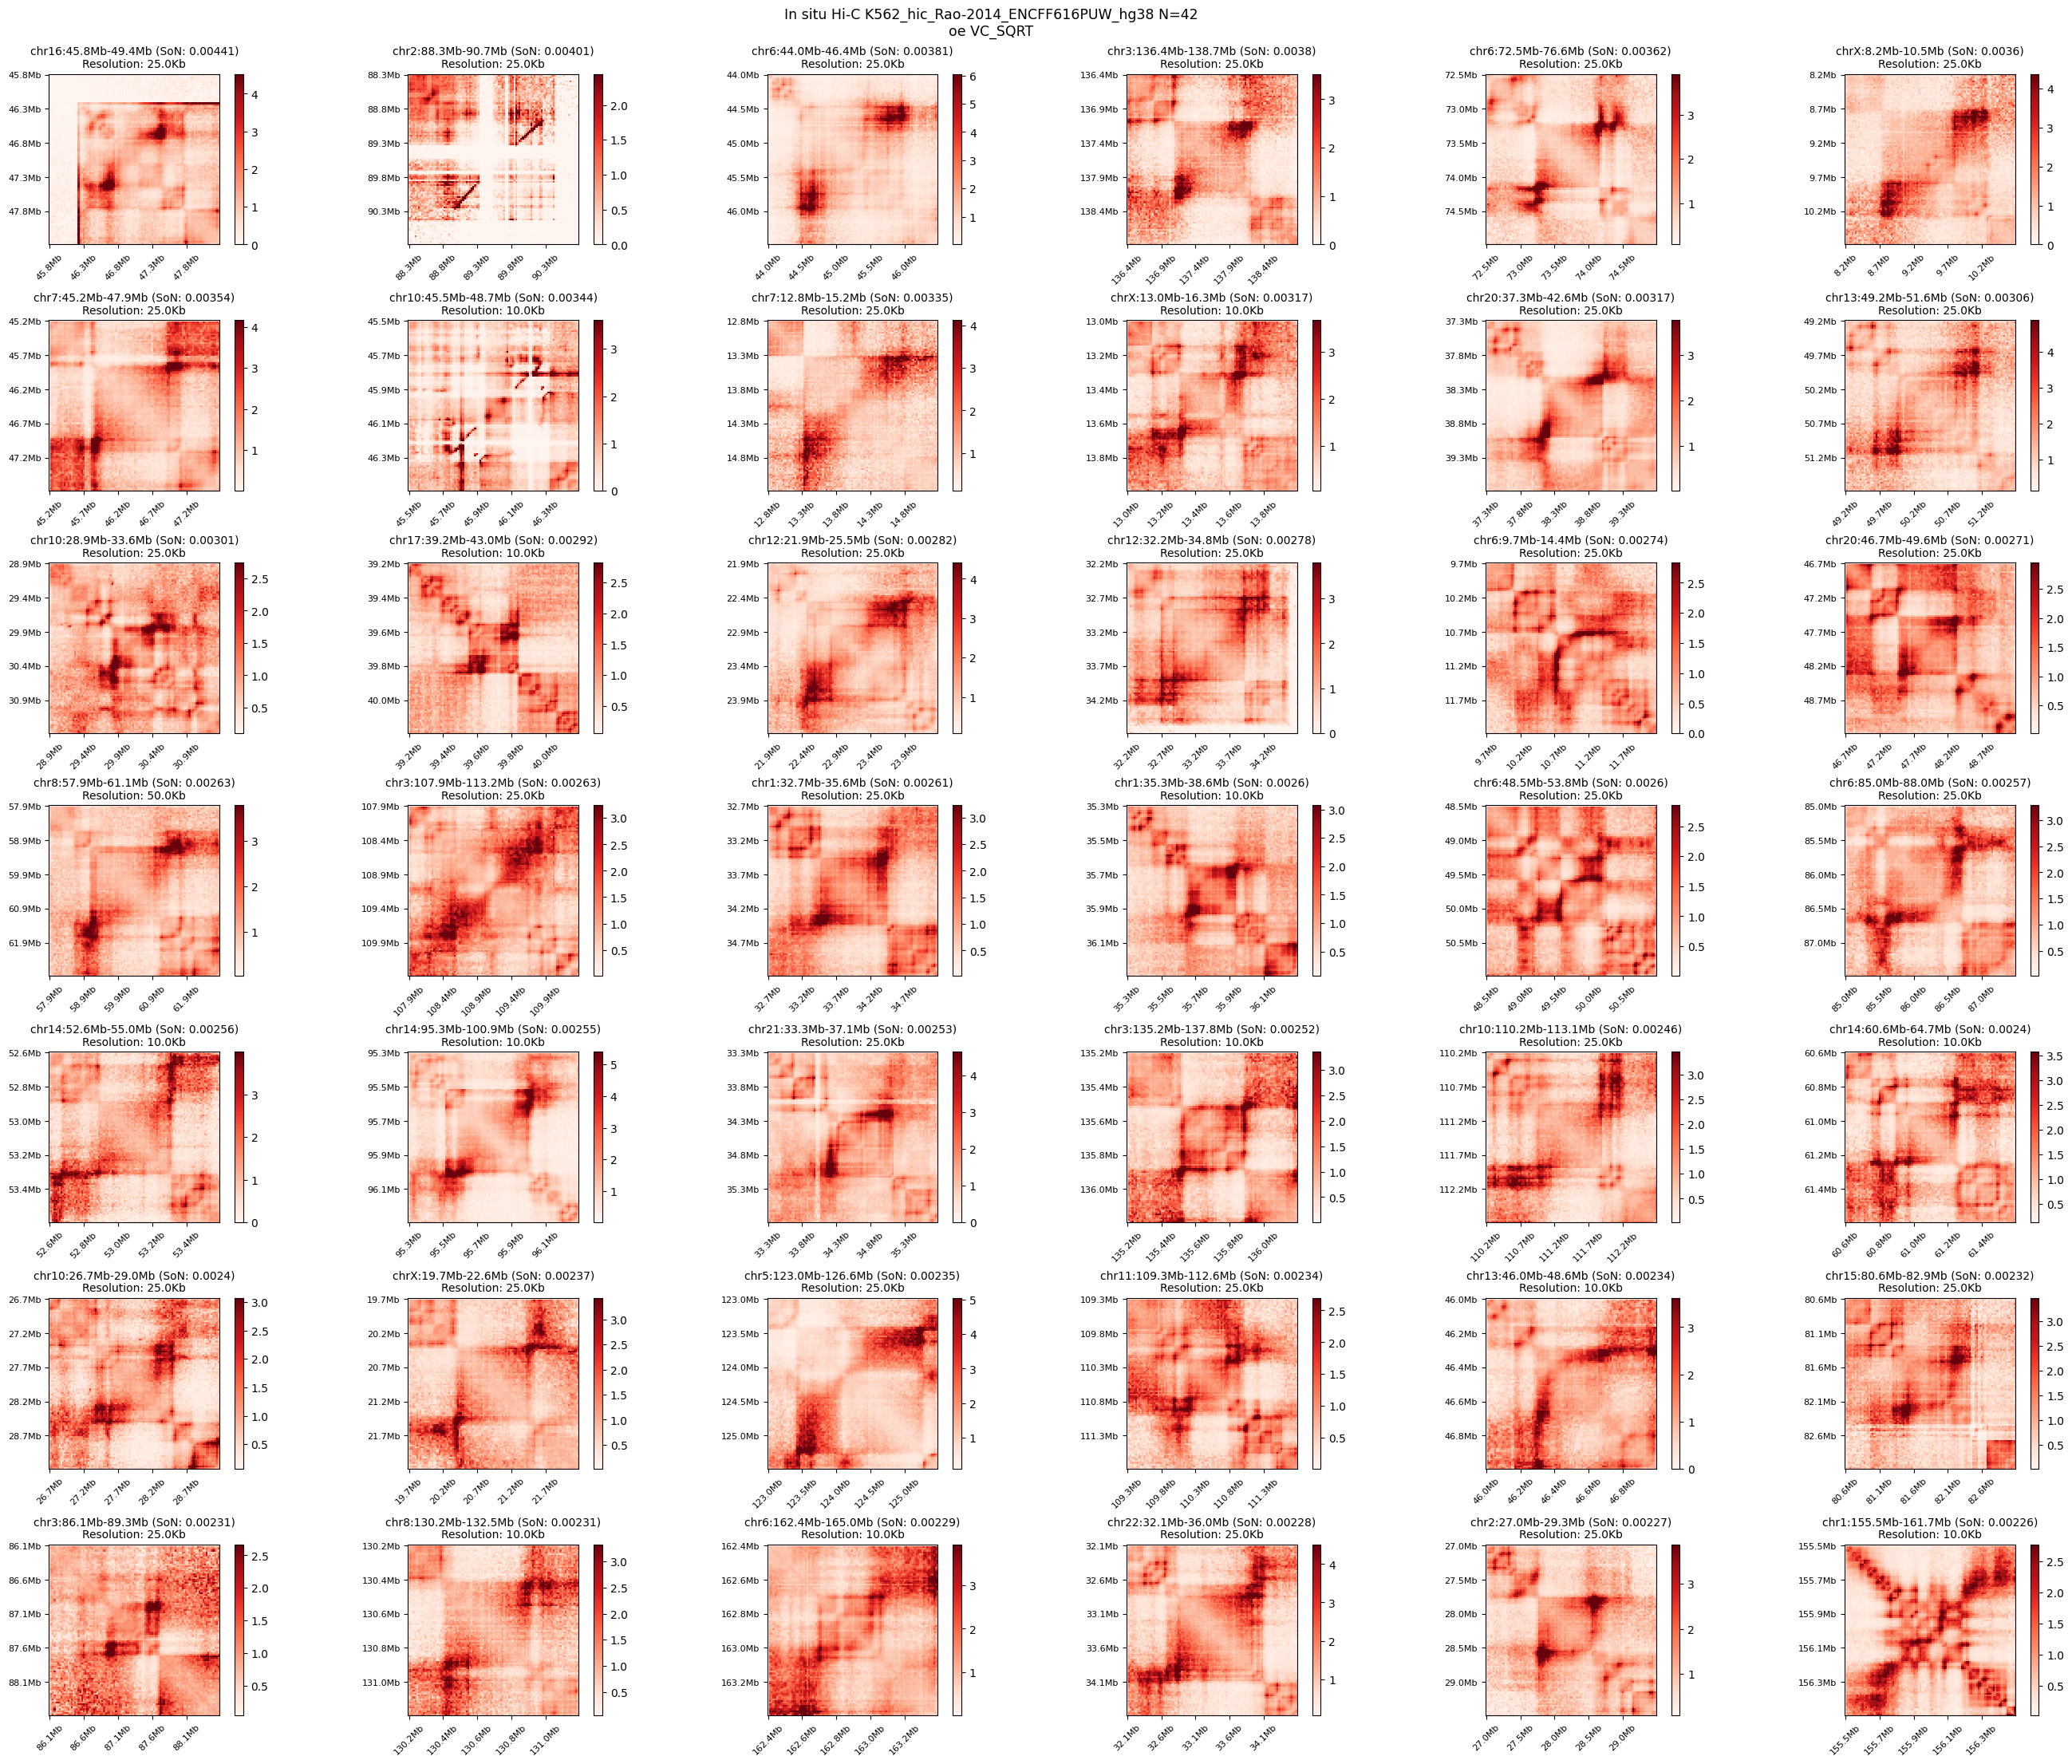

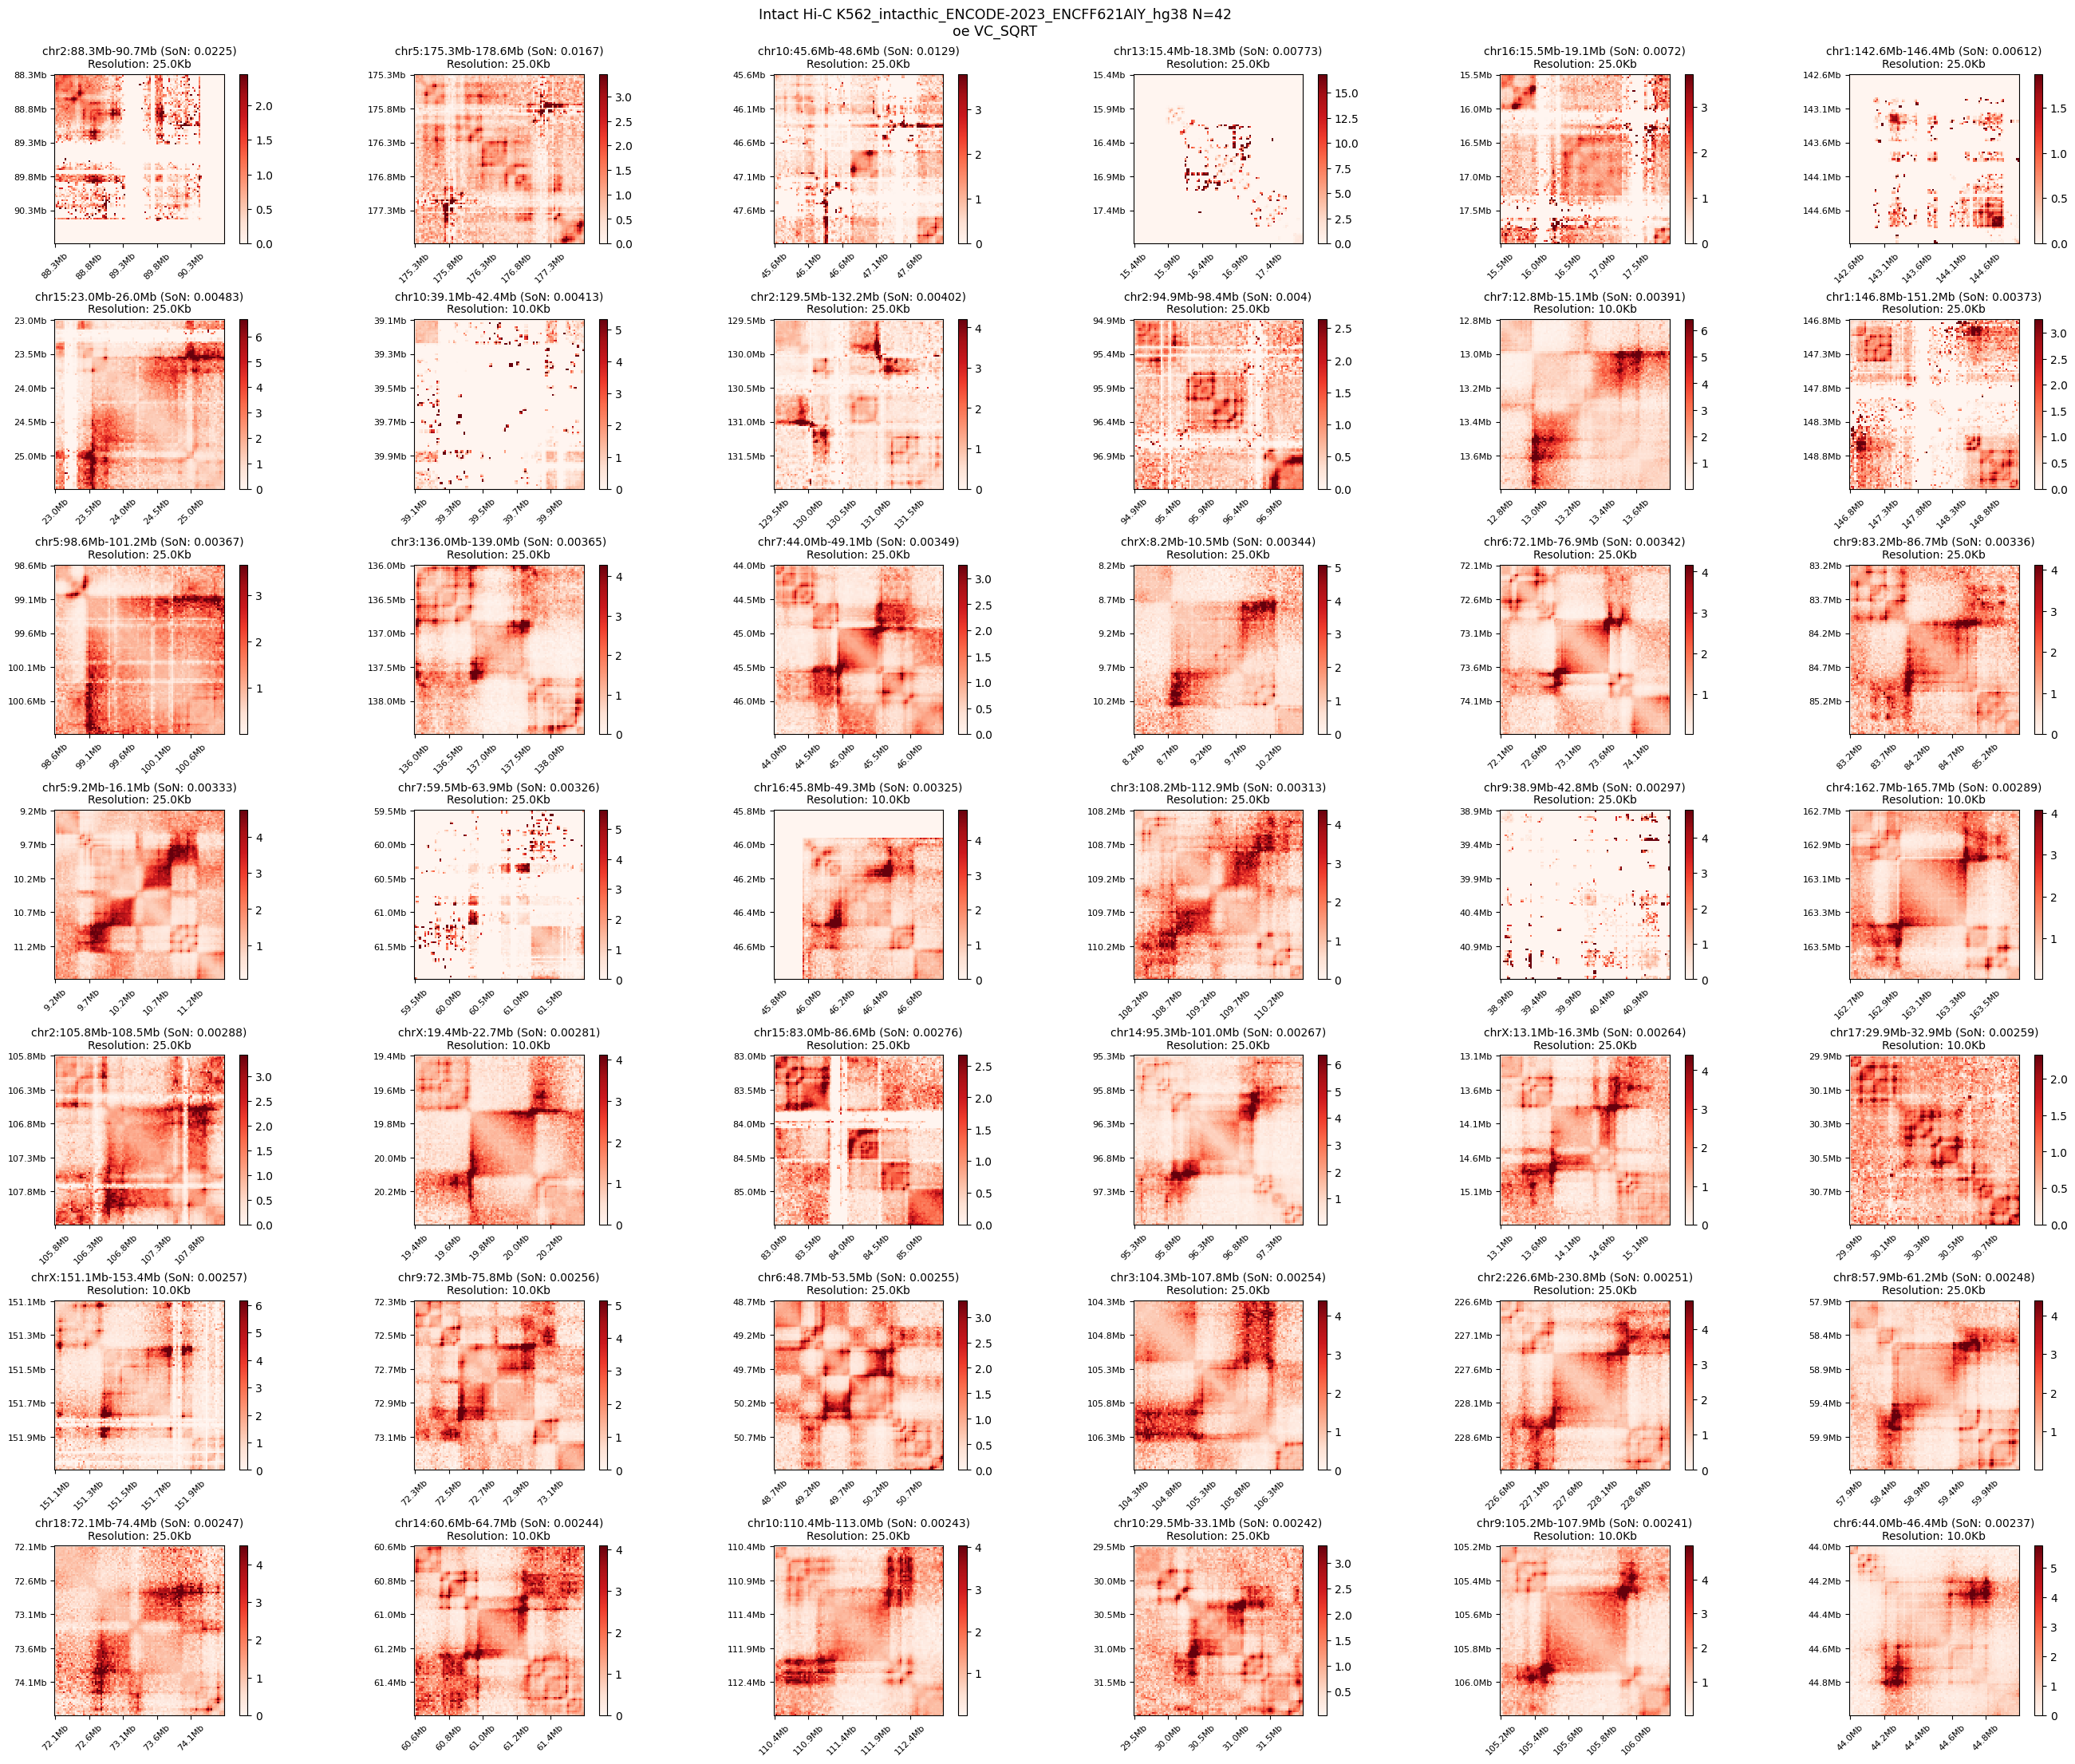

In [12]:
# PLOT DIAGNOSTIC OF TOP N

for idx in range(len(names)):
    
    suptitle = names[idx]

    # Select top jets according to "jet_saliency" column
    top_n = 42  
    # 1) get the original row‐indices of the top N
    top_idx = df_stack[idx].nlargest(top_n, ranking_col[select_method_idx]).index

    # 2) subset the DataFrame (and only then reset if you like)
    sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

    # 3) subset the array with those SAME indices
    sampled_stack = stacks[idx][top_idx]

    titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
    titles += f" ({ranking_col[select_method_idx]}: " + sampled_df_stack[ranking_col[select_method_idx]].map(lambda x : f"{x:.3g}") + ")"
    titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str) 
    titles = titles.tolist()

    genomic_shift = sampled_df_stack["start"].to_numpy()

    vmaxes = [np.percentile(s, 99) for s in sampled_stack]

    plot_n_hic(sampled_stack, 
            titles=titles, 
            resolution=resolutions[idx],
            suptitle=f"{suptitle} N={top_n}\n{data_type} {normalization}", 
            show=True, 
            genomic_shift=genomic_shift, 
            cmap_label=None, 
            vmax=vmaxes,
            ppr=6,
            savepath=f"{save_path}/{data_name}_individual-topN_{data_type}_{names[idx]}_{ranking_col[select_method_idx]}.png",
            cmap="Reds")

## Intersection

In [28]:
bed_tables[0]

chrom  window_start  window_end        FS  FS_peaks    Scharr  \
0    chr1       8050000    20100000  0.000041  0.000050  0.050575   
1    chr1      15750000    27800000  0.000026  0.000020  0.046696   
2    chr1      24350000    36400000  0.000019  0.000013  0.042538   
3    chr1      28600000    40650000  0.000026  0.000021  0.047915   
4    chr1      36000000    48050000  0.000030  0.000028  0.090370   
..    ...           ...         ...       ...       ...       ...   
388  chrX     107700000   119750000  0.000045  0.000043  0.110848   
389  chrX     115100000   127150000  0.000036  0.000036  0.226383   
390  chrX     120350000   132400000  0.000067  0.000072  0.134746   
391  chrX     126150000   138200000  0.000045  0.000038  0.256204   
392  chrX     137750000   149800000  0.000077  0.000090  0.379557   

      Scharr_box         root  unique_id  extrusion_x  extrusion_y  length  \
0     220.913348   14075000.0          0     20100000      8050000      -1   
1    1533.578868   21775000.0          1     27800000     15750000      -1   
2     185.805939   30375000.0          2     36400000     24350000      -1   
3     209.293356   34625000.0          3     40650000     28600000      -1   
4     394.735974   42025000.0          4     48050000     36000000      -1   
..           ...          ...        ...          ...          ...     ...   
388   842.848206  113725000.0        388    119750000    107700000      -1   
389   988.839469  121125000.0        389    127150000    115100000      -1   
390   600.998801  126375000.0        390    132400000    120350000      -1   
391  1119.099959  132175000.0        391    138200000    126150000      -1   
392  1657.905361  143775000.0        392    149800000    137750000      -1   

           start          end  
0      4537500.0   23612500.0  
1     12237500.0   31312500.0  
2     20837500.0   39912500.0  
3     25087500.0   44162500.0  
4     32487500.0   51562500.0  
..           ...          ...  
388  104187500.0  123262500.0  
389  111587500.0  130662500.0  
390  116837500.0  135912500.0  
391  122637500.0  141712500.0  
392  134237500.0  153312500.0  

[393 rows x 14 columns]

In [29]:
tables[0]

chrom      start        end  window_start  window_end        FS  FS_peaks  \
0    chr1   14050000   14100000       8050000    20100000  0.000041  0.000050   
1    chr1   21750000   21800000      15750000    27800000  0.000026  0.000020   
2    chr1   30350000   30400000      24350000    36400000  0.000019  0.000013   
3    chr1   34600000   34650000      28600000    40650000  0.000026  0.000021   
4    chr1   42000000   42050000      36000000    48050000  0.000030  0.000028   
..    ...        ...        ...           ...         ...       ...       ...   
388  chrX  113700000  113750000     107700000   119750000  0.000045  0.000043   
389  chrX  121100000  121150000     115100000   127150000  0.000036  0.000036   
390  chrX  126350000  126400000     120350000   132400000  0.000067  0.000072   
391  chrX  132150000  132200000     126150000   138200000  0.000045  0.000038   
392  chrX  143750000  143800000     137750000   149800000  0.000077  0.000090   

       Scharr   Scharr_box         root  unique_id  extrusion_x  extrusion_y  \
0    0.050575   220.913348   14075000.0          0     20100000      8050000   
1    0.046696  1533.578868   21775000.0          1     27800000     15750000   
2    0.042538   185.805939   30375000.0          2     36400000     24350000   
3    0.047915   209.293356   34625000.0          3     40650000     28600000   
4    0.090370   394.735974   42025000.0          4     48050000     36000000   
..        ...          ...          ...        ...          ...          ...   
388  0.110848   842.848206  113725000.0        388    119750000    107700000   
389  0.226383   988.839469  121125000.0        389    127150000    115100000   
390  0.134746   600.998801  126375000.0        390    132400000    120350000   
391  0.256204  1119.099959  132175000.0        391    138200000    126150000   
392  0.379557  1657.905361  143775000.0        392    149800000    137750000   

     length  
0        -1  
1        -1  
2        -1  
3        -1  
4        -1  
..      ...  
388      -1  
389      -1  
390      -1  
391      -1  
392      -1  

[393 rows x 14 columns]

In [13]:
def liftover(df, chrom_col, start_col, end_col, liftover_path, chain_path, work_dir="../temp"):
    """
    Perform UCSC liftOver using fixed filenames in work_dir:
      - writes work_dir/in.bed
      - produces work_dir/out.bed and work_dir/unmapped.bed
    Returns df with chrom_new, start_new, end_new appended
    """
    bed_path    = f"{work_dir}/in.bed"
    out_path    = f"{work_dir}/out.bed"
    unmapped_path = f"{work_dir}/unmapped.bed"

    # make bed dataframe for export
    bed_df = pd.DataFrame({
        'chrom': df[chrom_col].astype(str),
        'start': np.round(df[start_col]).astype(int),
        'end':   np.round(df[end_col]).astype(int),
    })
    bed_df.to_csv(bed_path, sep='\t', header=False, index=False)

    # run liftover
    subprocess.run(
        [liftover_path, bed_path, chain_path, out_path, unmapped_path],
        check=True
    )

    # read results
    df_out = pd.read_csv(out_path, sep='\t', header=None,
                         names=[f'{chrom_col} remapped', f'{start_col} remapped', f'{end_col} remapped'])

    # clean up files
    # os.remove(bed_path); os.remove(out_path); os.remove(unmapped_path)

    return pd.concat([df.reset_index(drop=True), df_out], axis=1)

In [14]:
f_liftover = "/nfs/turbo/umms-minjilab/packages/linux.x86_64/liftOver"
f_chain = "/nfs/turbo/umms-minjilab/processing/genomes/hg38ToHg19.over.chain"

In [15]:
for idx in range(len(names)):

    g = genomes[idx]

    if g == "hg38":
        # Then we map over the coordinates

        # TABLE MAPPING (DIRECT LIFTOVER OF BED TABLE)
        table_dict[names[idx]] = liftover(df=table_dict[names[idx]], chrom_col="chrom", start_col="start", end_col="end", 
                                          liftover_path=f_liftover, chain_path=f_chain)
        
        # POSITION MAPPING (CONVERT AND LIFTOVER)
        # need to preprocess the positions to have "start" and "end" columns
        position_copy = position_dict[names[idx]].copy()

        # we should map each "x (bp)" to have a start and end and run each independently
        position_copy["chrom x"] = position_copy["chrom"]
        position_copy["start x"] = np.floor(position_copy["x (bp)"]).astype(int)
        position_copy["end x"] = position_copy["start x"] + 1

        position_copy["chrom y"] = position_copy["chrom"]
        position_copy["start y"] = np.floor(position_copy["y (bp)"]).astype(int)
        position_copy["end y"] = position_copy["start y"] + 1

        # perform UCSC liftover
        position_copy = liftover(df=position_copy, chrom_col="chrom x", start_col="start x", end_col="end x", 
                                liftover_path=f_liftover, chain_path=f_chain)
        

        position_copy = liftover(df=position_copy, chrom_col="chrom y", start_col="start y", end_col="end y", 
                                liftover_path=f_liftover, chain_path=f_chain)
        
        position_copy.rename({"start x remapped" : "x (bp) remapped", "start y remapped" : "y (bp) remapped", "chrom x remapped" : "chrom remapped"},
                              axis=1, inplace=True)
        
        position_copy.drop(columns=["end x remapped", "end y remapped", "chrom y remapped"], inplace=True)

        # Drop NANs from liftover
        position_copy.dropna(inplace=True)

        position_dict[names[idx]] = position_copy

    else:
        # If we do not need to perform any liftover
        # We will still copy over the data into the new columns "chrom remapped", "x (bp) remapped", "y (bp) remapped"
        # This is the consistency of the overlapping code below

        table_dict[names[idx]]["chrom remapped"] = table_dict[names[idx]]["chrom"]
        table_dict[names[idx]]["start remapped"] = table_dict[names[idx]]["start"]
        table_dict[names[idx]]["end remapped"] = table_dict[names[idx]]["end"]

        position_dict[names[idx]]["chrom remapped"] = position_dict[names[idx]]["chrom"]
        position_dict[names[idx]]["x (bp) remapped"] = position_dict[names[idx]]["x (bp)"]
        position_dict[names[idx]]["y (bp) remapped"] = position_dict[names[idx]]["y (bp)"]

Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [16]:
# COMPUTE OVERLAPS
results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
unique_identifiers = []
name_pairs = []
# fill main diagonal with the total number of jets from each method
for n in names:
    results.loc[n, n] = len(table_dict[n])

In [17]:
for n1, n2 in itertools.combinations(names, 2):

    print("-" * 20)
    print(f"Comparing {n1} and {n2}...")

    genome_wide_overlap = 0
    identifiers = []

    for chrom in common_chroms:

        # IOU method is per-chromosome so filter each table by chromosome
        t1 = position_dict[n1].loc[position_dict[n1]["chrom remapped"] == chrom]
        t2 = position_dict[n2].loc[position_dict[n2]["chrom remapped"] == chrom]

        # Summary tables to get the number of jets called by each method
        s1 = table_dict[n1].loc[table_dict[n1]["chrom remapped"] == chrom]
        s2 = table_dict[n2].loc[table_dict[n2]["chrom remapped"] == chrom]


        if t1.empty or t2.empty:
            # if any of the two tables are empty then no need to check for overlaps.. there is none
            continue

        # Compute the pairs of jets in each direction
        pairs12 = match_by_iou(t1, t2, buffer_radius=buffer_radius, iou_threshold=iou_threshold, x_label="x (bp) remapped", y_label="y (bp) remapped")
        pairs21 = match_by_iou(t2, t1, buffer_radius=buffer_radius, iou_threshold=iou_threshold, x_label="x (bp) remapped", y_label="y (bp) remapped")

        # Construct graph and find unique pairs
        pairs = unique_pairs(pairs12, pairs21, method="optimal")

        # print(f"* {chrom}: {len(pairs)} pairs between {n1} ({len(s1)}) and {n2} ({len(s2)})")

        genome_wide_overlap += len(pairs)
        identifiers += pairs # extend the list

    # Update reuslts table
    results.loc[n1, n2] = genome_wide_overlap
    results.loc[n2, n1] = genome_wide_overlap  # symmetric

    unique_identifiers.append(identifiers)
    name_pairs.append((n1, n2))
    
print("Genome-wide overlaps:")
print(results)

--------------------
Comparing Repli-HiC_K562_WT_totalS (hg19) and In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38...
--------------------
Comparing Repli-HiC_K562_WT_totalS (hg19) and Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38...
--------------------
Comparing In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38 and Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38...
Genome-wide overlaps:
                                                    Repli-HiC_K562_WT_totalS (hg19)  \
Repli-HiC_K562_WT_totalS (hg19)                                               557.0   
In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38                               167.0   
Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621...                            194.0   

                                                    In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38  \
Repli-HiC_K562_WT_totalS (hg19)                                                               167.0   
In situ Hi-C K562_hic_Rao-2014_ENCFF6

In [18]:
results

Repli-HiC_K562_WT_totalS (hg19)  \
Repli-HiC_K562_WT_totalS (hg19)                                               557.0   
In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38                               167.0   
Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621...                            194.0   

                                                    In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38  \
Repli-HiC_K562_WT_totalS (hg19)                                                               167.0   
In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38                                               343.0   
Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621...                                            249.0   

                                                    Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38  
Repli-HiC_K562_WT_totalS (hg19)                                                                 194.0        
In situ Hi-C K562_hic_Rao-2014_ENCFF616PUW_hg38                                                 249.0        
Intact Hi-C K562_intacthic_ENCODE-2023_ENCFF621...                                              383.0

In [19]:
ranking_col

['jet_saliency', 'SoN', 'FS_peaks']

In [20]:
genomes

['hg19', 'hg38', 'hg38']

In [21]:
def safe_int(x):
    try:
        return int(x)
    except ValueError:
        return x

In [22]:
# COLLECT AGG DATA / PLOT DIAGNOSTIC OVERLAPS
agg_map_pairs = [] # aggregate contact map data
jet_strength_pairs = [] # jet strength correlation data
for (n1, n2), pairs in zip(name_pairs, unique_identifiers):
    safe_convert = np.vectorize(safe_int)
    df_intersections = []

    if len(pairs) == 0:
        uid1 = np.array([])  
        uid2 = np.array([])  
    else:
        uid1 = np.array(pairs)[:, 0]  # unique identifiers from n1
        uid2 = np.array(pairs)[:, 1]  # unique identifiers from n2

        uid1 = safe_convert(uid1)
        uid2 = safe_convert(uid2)

    df1 = pd.DataFrame({"unique_id" : uid1,})
    df2 = pd.DataFrame({"unique_id" : uid2,})
    # Use n1
    A_name = n1
    B_name = n2
    # Summary dataframe
    df_A = table_dict[n1]
    df_B = table_dict[n2]
    # These will be used to merge to extract the relevant positions
    df_id = df1
    df_id_alt = df2
    # Expanded dataframe 
    df_pos_A = position_dict[n1].copy()
    df_pos_B = position_dict[n2].copy()

    # These are the "main" summary dataframes
    # That should be sufficien to plot the aggregate contact maps and boxplots
    df_intersection = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_A = df_A[~df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_B = df_B[~df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    jet_strength_pairs.append([df_diff_A[ranking_col[select_method_idx]].values, 
                               df_intersection[ranking_col[select_method_idx]].values, 
                               df_diff_B[ranking_col[select_method_idx]].values])

    # Assertions to ensure that the intersection and difference cover the whole table
    # assert len(df_intersection) + len(df_diff_A) == len(df_A), "The intersection and difference should cover the whole table"
    # assert len(df_intersection) + len(df_diff_B) == len(df_B), "The intersection and difference should cover the whole table"

    A_idx = names.index(n1)
    B_idx = names.index(n2)


    # AGGREGATE CONTACT MAPS
    # Lets get the positions, which is better to plot the individual Hi-C diagnostic plots
    # These diagnostic plots are meant to confirm that the overlapping parameters are good
    df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_A = df_pos_A[~df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_B = df_pos_B[~df_pos_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    # plot_overlap_diagnostic(
    #     hic_file=hic_file,
    #     plot_chrom=common_chroms[0],  
    #     resolution=resolution,
    #     data_type="observed",
    #     normalization=normalization,
    #     A_name=A_name,
    #     B_name=B_name,
    #     df_pos_A=df_pos_A,
    #     df_pos_B=df_pos_B,
    #     df_pos_intersection=df_pos_intersection,
    #     df_pos_diff_A=df_pos_diff_A,
    #     df_pos_diff_B=df_pos_diff_B,
    #     save_path=save_path,
    #     data_name=data_name
    # )

    # Make bed files to get stacks
    bed_intersection = generate_bed_2(df_intersection, df_pos_intersection, eps=500e3, fraction=1.5)
    bed_diff_A = generate_bed_2(df_diff_A, df_pos_diff_A, eps=500e3, fraction=1.5)
    bed_diff_B = generate_bed_2(df_diff_B, df_pos_diff_B, eps=500e3, fraction=1.5)


    bed_frames = [bed_diff_A, bed_intersection, bed_diff_B]
    bed_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]
    chrom_sizes_comparison = [bf.fetch_chromsizes(genomes[A_idx]), bf.fetch_chromsizes(genomes[A_idx]), bf.fetch_chromsizes(genomes[B_idx])]
    hic_file_comparison = [hic_file[A_idx], hic_file[A_idx], hic_file[B_idx]]

    agg_map = []
    # resolutions = []
    for j, (bed_df, name) in enumerate(zip(bed_frames, bed_names)):
        # Get pileups for each bed_df
        s, d, r = get_pileups_dynamic_resolution(
            hic_file=hic_file_comparison[j],
            bed_df_in=bed_df,
            expected_stack_size=expected_stack_size,
            chrom_sizes=chrom_sizes_comparison[j],
            chromosomes='all',
            window_range=(None, None),
            data_type=data_type,
            normalization=normalization,
            sort=True,
            verbose=True
        )

        # Remove centromeres and resize square stacks
        s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

        if data_type == "observed":
            s = np.log10(s + 1) # log transform for visualization

        agg_map.append(np.mean(s, axis=0))  # average over all stacks
        # resolutions.append(r)

    agg_map_pairs.append(agg_map)

agg_map_pairs = np.array(agg_map_pairs)


Retrieving pileups: 100%|██████████| 134/134 [00:10<00:00, 12.33it/s]


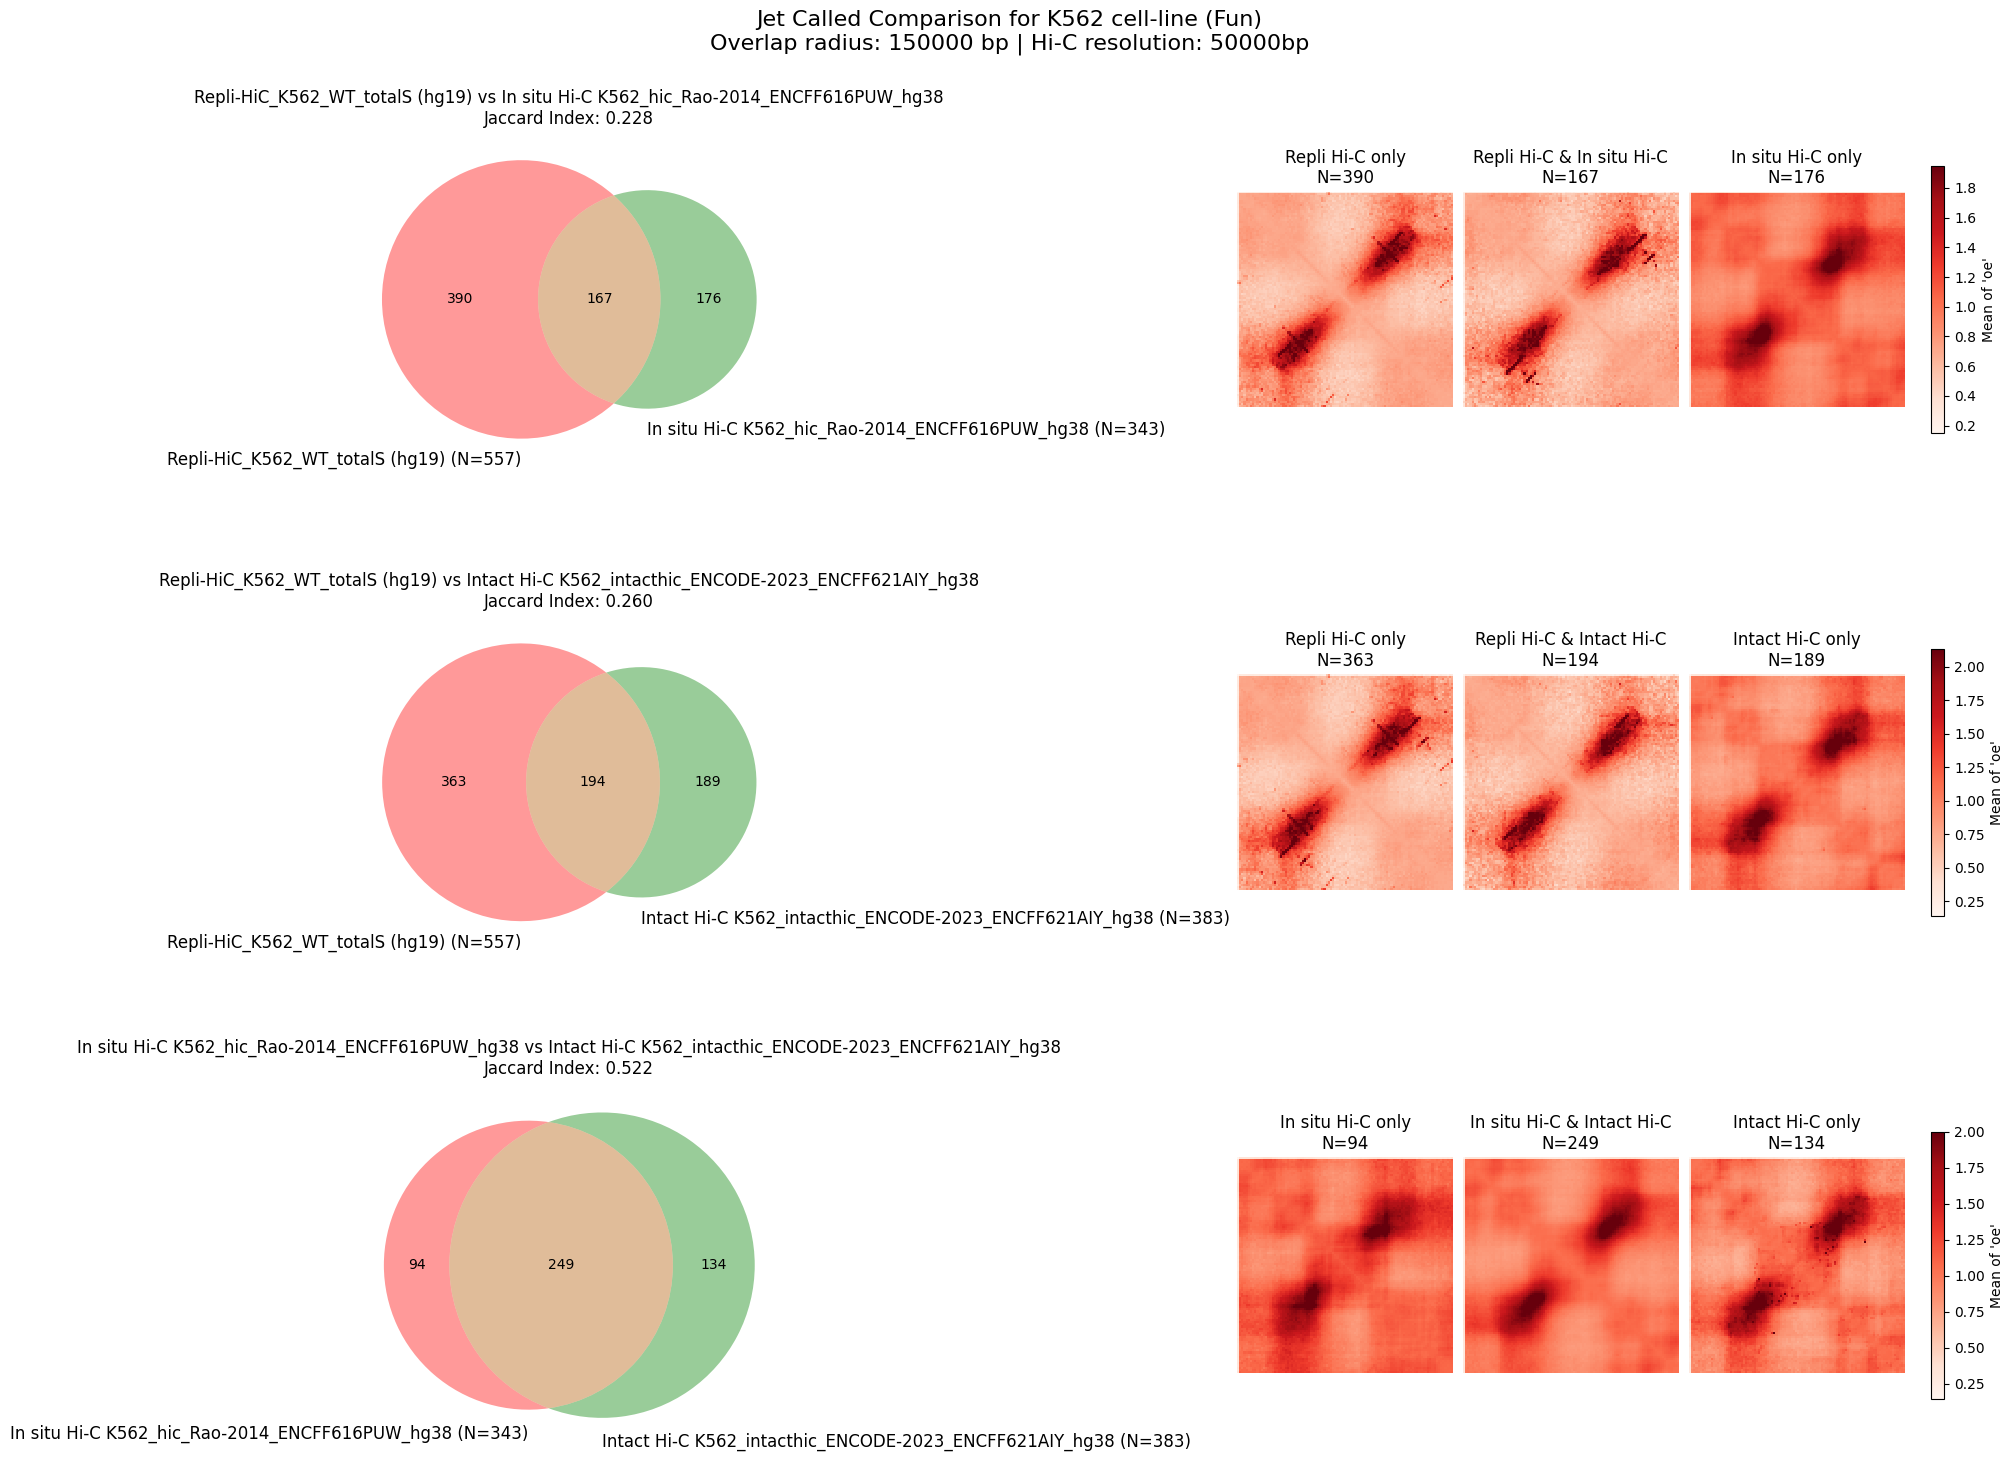

In [23]:
# PLOT VENN DIAGRAM
pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)

fig, axes = plt.subplots(num_pairs, 4, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1, 1, 1])

for row, (A, B) in enumerate(pairs):
    # compute overlaps as before
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter = results.loc[A, B]
    only_A = total_A - inter
    only_B = total_B - inter

    # column 0: the Venn
    ax = axes[row, 0]
    venn2(subsets=(int(only_A), int(only_B), int(inter)),
        set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
        ax=ax)
    ax.set_title(f"{A} vs {B}\nJaccard Index: {inter / (inter + only_A + only_B):.3f}")

    # columns 1–3: the three imshows
    # agg_map_pairs.shape == (n_pairs, 3, H, W)
    A_idx = names.index(A)
    B_idx = names.index(B)
    A_abbrev = names_abbrev[A_idx]
    B_abbrev = names_abbrev[B_idx]
    titles = [f"{A_abbrev} only", f"{A_abbrev} & {B_abbrev}", f"{B_abbrev} only"]
    counts = [int(only_A), int(inter), int(only_B)]
    row_imgs = agg_map_pairs[row]
    row_vmax = max(np.percentile(img, 99) for img in row_imgs)
    for col_idx in range(3):
        ax = axes[row, col_idx+1]
        img = agg_map_pairs[row, col_idx]
        im = ax.imshow(img, cmap="Reds", interpolation="none", vmax=np.percentile(img, 99))
        ax.set_title(f"{titles[col_idx]}\nN={counts[col_idx]}")
        ax.axis('off')
    fig.colorbar(im, ax=axes[row, 1:], fraction=0.02, pad=0.04, label=f"Mean of '{data_type}'")


fig.suptitle(f"Jet Called Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_venn_diagram-agg.png", dpi=300)

plt.show()


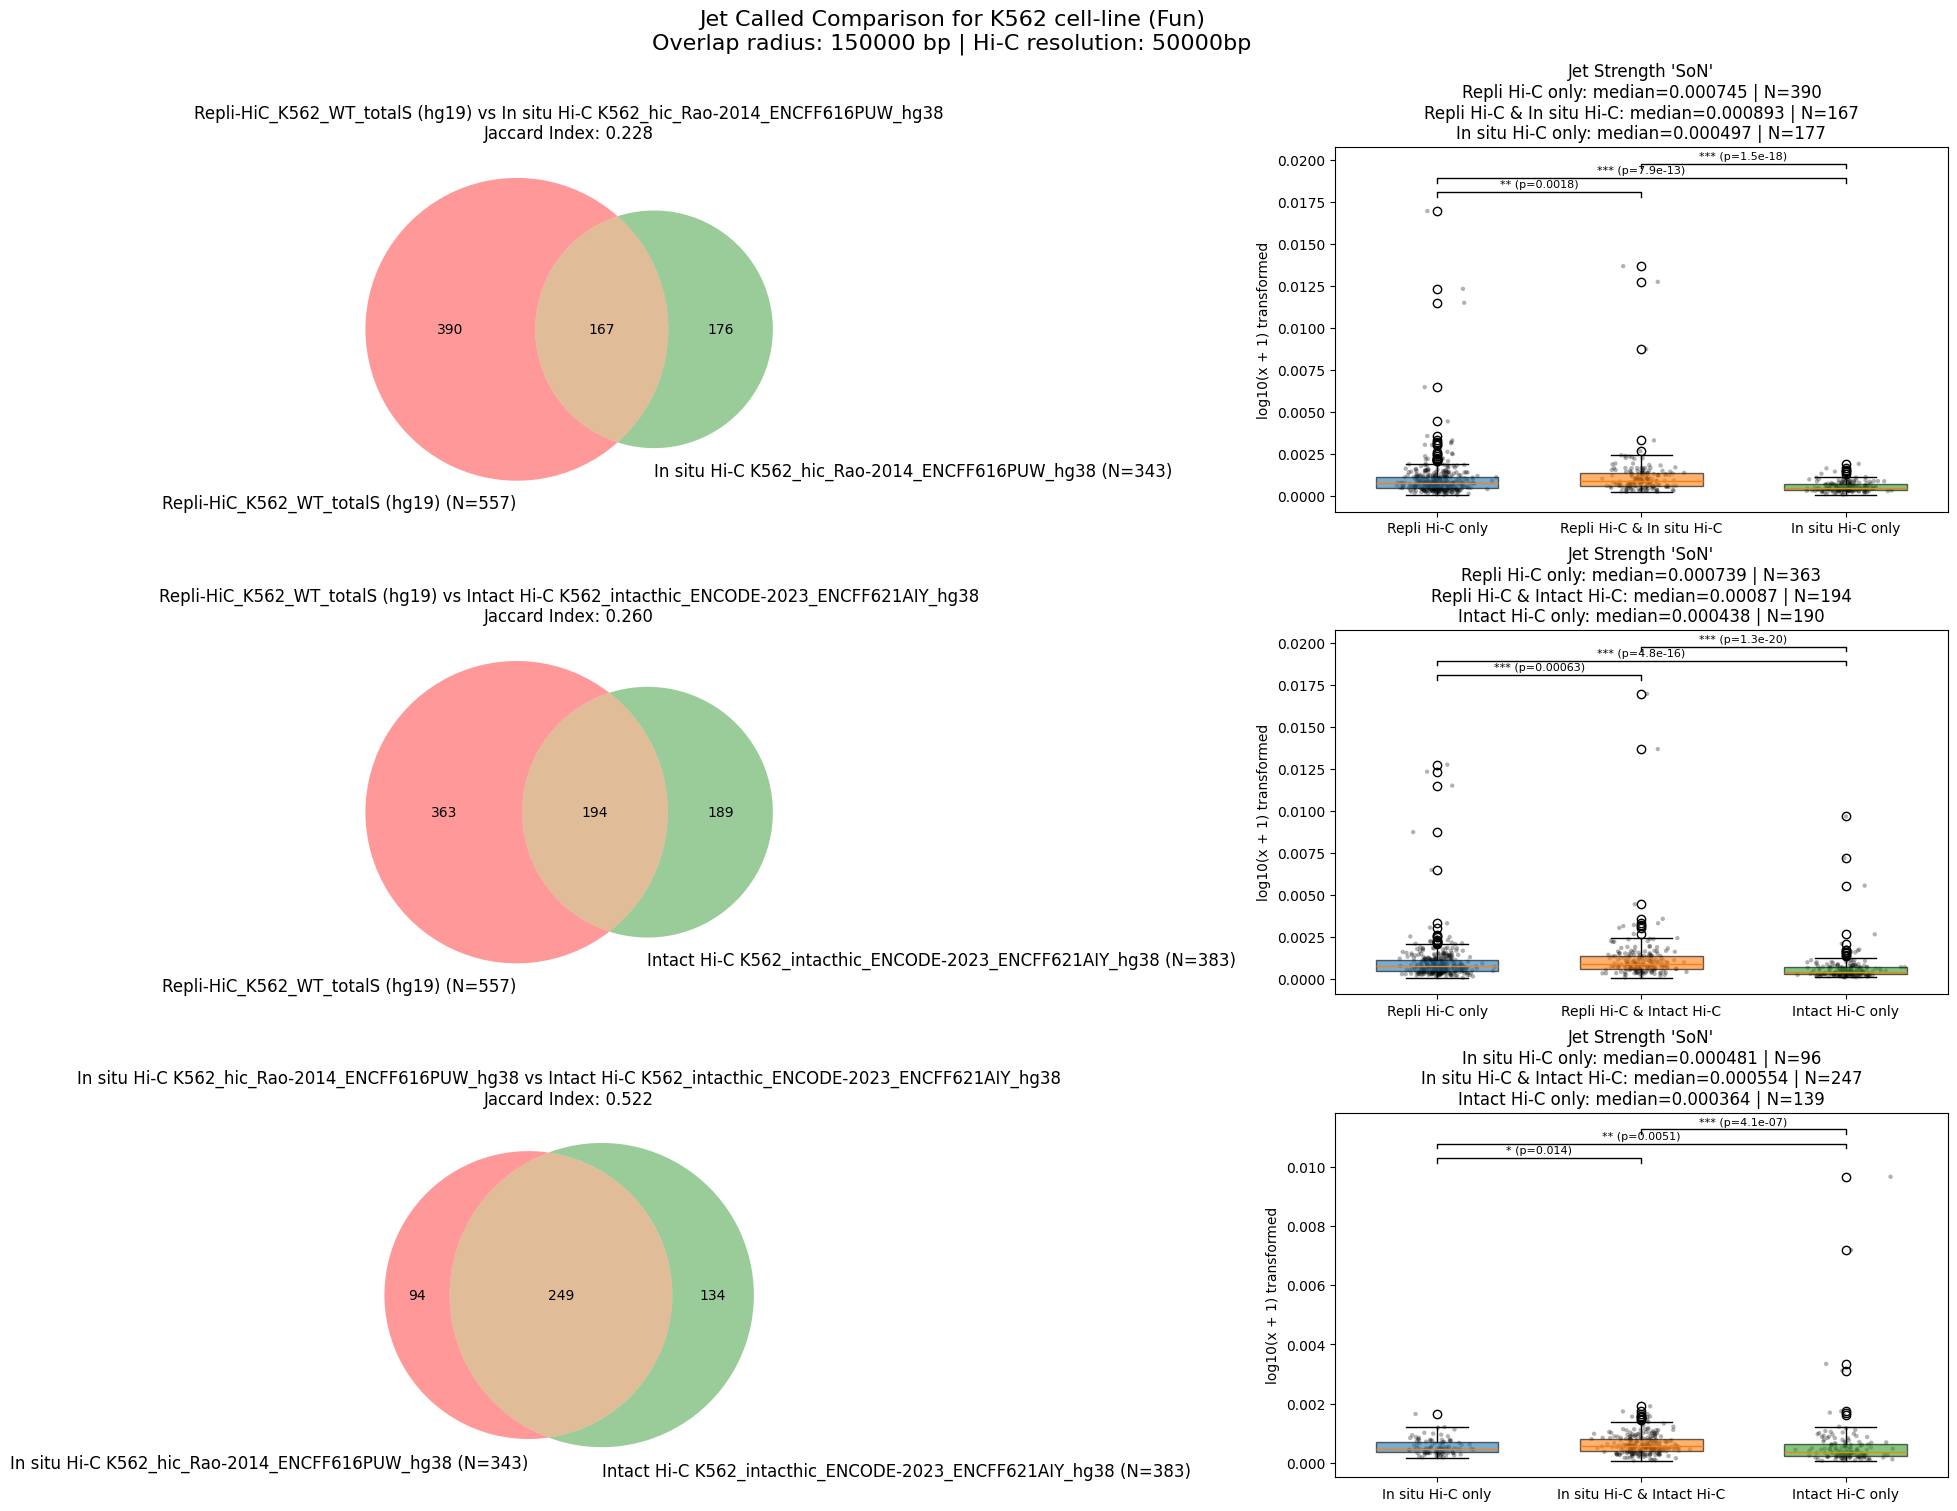

In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# PLOT VENN DIAGRAM
pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)

fig, axes = plt.subplots(num_pairs, 2, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1])

for row, (A, B) in enumerate(pairs):
    # compute overlaps as before
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter = results.loc[A, B]
    only_A = total_A - inter
    only_B = total_B - inter

    # column 0: the Venn
    ax = axes[row, 0]
    venn2(subsets=(int(only_A), int(only_B), int(inter)),
        set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
        ax=ax)
    ax.set_title(f"{A} vs {B}\nJaccard Index: {inter / (inter + only_A + only_B):.3f}")

    # columns 1–3: the three imshows
    # agg_map_pairs.shape == (n_pairs, 3, H, W)
    A_idx = names.index(A)
    B_idx = names.index(B)
    A_abbrev = names_abbrev[A_idx]
    B_abbrev = names_abbrev[B_idx]
    titles = [f"{A_abbrev} only", f"{A_abbrev} & {B_abbrev}", f"{B_abbrev} only"]
    counts = [int(only_A), int(inter), int(only_B)]

    # Instead of 3 columns, plot just one boxplot but side by side
    ax = axes[row, 1]

    # boxplot specific variables
    positions = np.arange(1, 4) # 4-1=3 because A only, intersection, B only
    points = jet_strength_pairs[row]
    points = [np.clip(vals, 0, None) for vals in points]
    points = [np.log10(x + 1) for x in points]

    add_pairwise_sig(ax, positions, points)

    bp = ax.boxplot(points, patch_artist=True, positions=positions, widths=0.6)

    # color each box
    for patch, col in zip(bp['boxes'], colors[:3]):
        patch.set_facecolor(col)
        patch.set_alpha(0.6)

    # jittered scatter on top
    for j, vals in enumerate(points):
        y = np.array(vals)
        x = np.full_like(y, positions[j], dtype=float) + np.random.normal(0, 0.08, size=len(y))
        ax.scatter(x, y, alpha=0.3, s=10, color='k', edgecolor='none')

    title_boxstat = title_boxplot(f"Jet Strength '{ranking_col[select_method_idx]}'", titles, points)
    ax.set_title(title_boxstat)

    # x-tick labels
    ax.set_xticks(positions)
    ax.set_xticklabels(titles, rotation=0)

    ax.set_ylabel("log10(x + 1) transformed")


fig.suptitle(f"Jet Called Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_venn_diagram-jetstrength.png", dpi=300)

plt.show()
